<div style='background-image: url("https://i.ibb.co/2t6jDtW/igte-tu-banner.png") ; padding: 0px ; background-size: 40% 130% ; background-repeat: no-repeat; border-radius: 5px ; height: 250px'>
<div style="position: absolute; top: 100px; left: 260px; border-radius: 10px; background: rgba(212, 212, 212, 0.6) ; width:600px; height: 150px">
<div style="position: relative; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; padding-top: 5px; padding-left: 130px ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">Optimization I : HW-1</div>
            <div style="font-size: large ; padding-top: 20px ; padding-left: 135px ; color: rgba(0 , 0 , 0 , 0.6)">Bracketing, Sectioning and Line Search</div>
            <div style="font-size: small ; padding-top: 5px ; padding-left: 25px ; color: rgba(0 , 0 , 0 , 0.4)">18.10.2023 </div>
                    <div style="font-size: small ; padding-top: 0px ; padding-left: 25px ; color: rgba(0 , 0 , 0 , 0.4)">Group Nr. 05, Haris Felic ( 01609136 ), Benedikt Gasplmayr ( 01530104 ) </div>
        </div>
    </div>
</div>

## Task 1 ( 1D - problem ) :
Assuming that there is no available derivative information for the univariate function to be optimized (which is often the case in real-world scenarios), the bracketing method is employed to identify an interval containing a local minimum. Once these initial brackets are determined, the interval is progressively reduced until a specific stopping criterion is met. This iterative process is referred to as sectioning.

You are tasked with implementing the bracketing and sectioning (golden section search) algorithm as independent functions, allowing for easy substitution of the function to be minimized. As specified in the template file, the 'line_search()' function acts as a wrapper, calling the bracketing and sectioning functions. Despite the line search algorithm being used exclusively for problems with dimensions greater than one, you should utilize the same code for both 1D and 2D problems."

In [138]:
from typing import Callable, List, Tuple
from dataclasses import dataclass
import numpy as np

import matplotlib.pyplot as plt
import test_functions as tf
from matplotlib import pyplot

############ Solution functions ################
# The function bodies in the following section #
# are to be edited. The function input params  #
# and return values along with the function    #
# name must not change as well as the imports  #
################################################

############ Global variables #################
rho: float = 0.61803398875
state: str = True

The bracketing function is summarized as follows: Beginning at a given point a, a positive step of length s is taken (resulting in b = a + a). Following this, another step is executed in the downhill direction using the same step size. This direction is discernible by comparing the function value at the starting point to that at the first point (f(a) <> f(b)). 

With each subsequent step, the step size is expanded by an additional hyper parameter k. When f(c) surpasses the value of f(b), indicating that the middle point b has the lowest function value (f(a) > f(b) < f(c)), the brackets are established using a and c.

In [139]:
def bracketing(
        a: float,
        s: float,
        k: float,
        f: Callable,
        max_it: float = 10e3,
        ):
    b = a + s
    i = 1

    if f(a)>f(b):
        pass
    else:
        a,b = b,a
        s = -s
    c = b + s

    while state == True:        
        i +=1
        if f(c) > f(b):
            break
        elif i > max_it:
            print("Max. iterations reached!")
            break
        else:
            a = b
            b = c
            s = s * k
            c = b + s
    return a,b,c,i

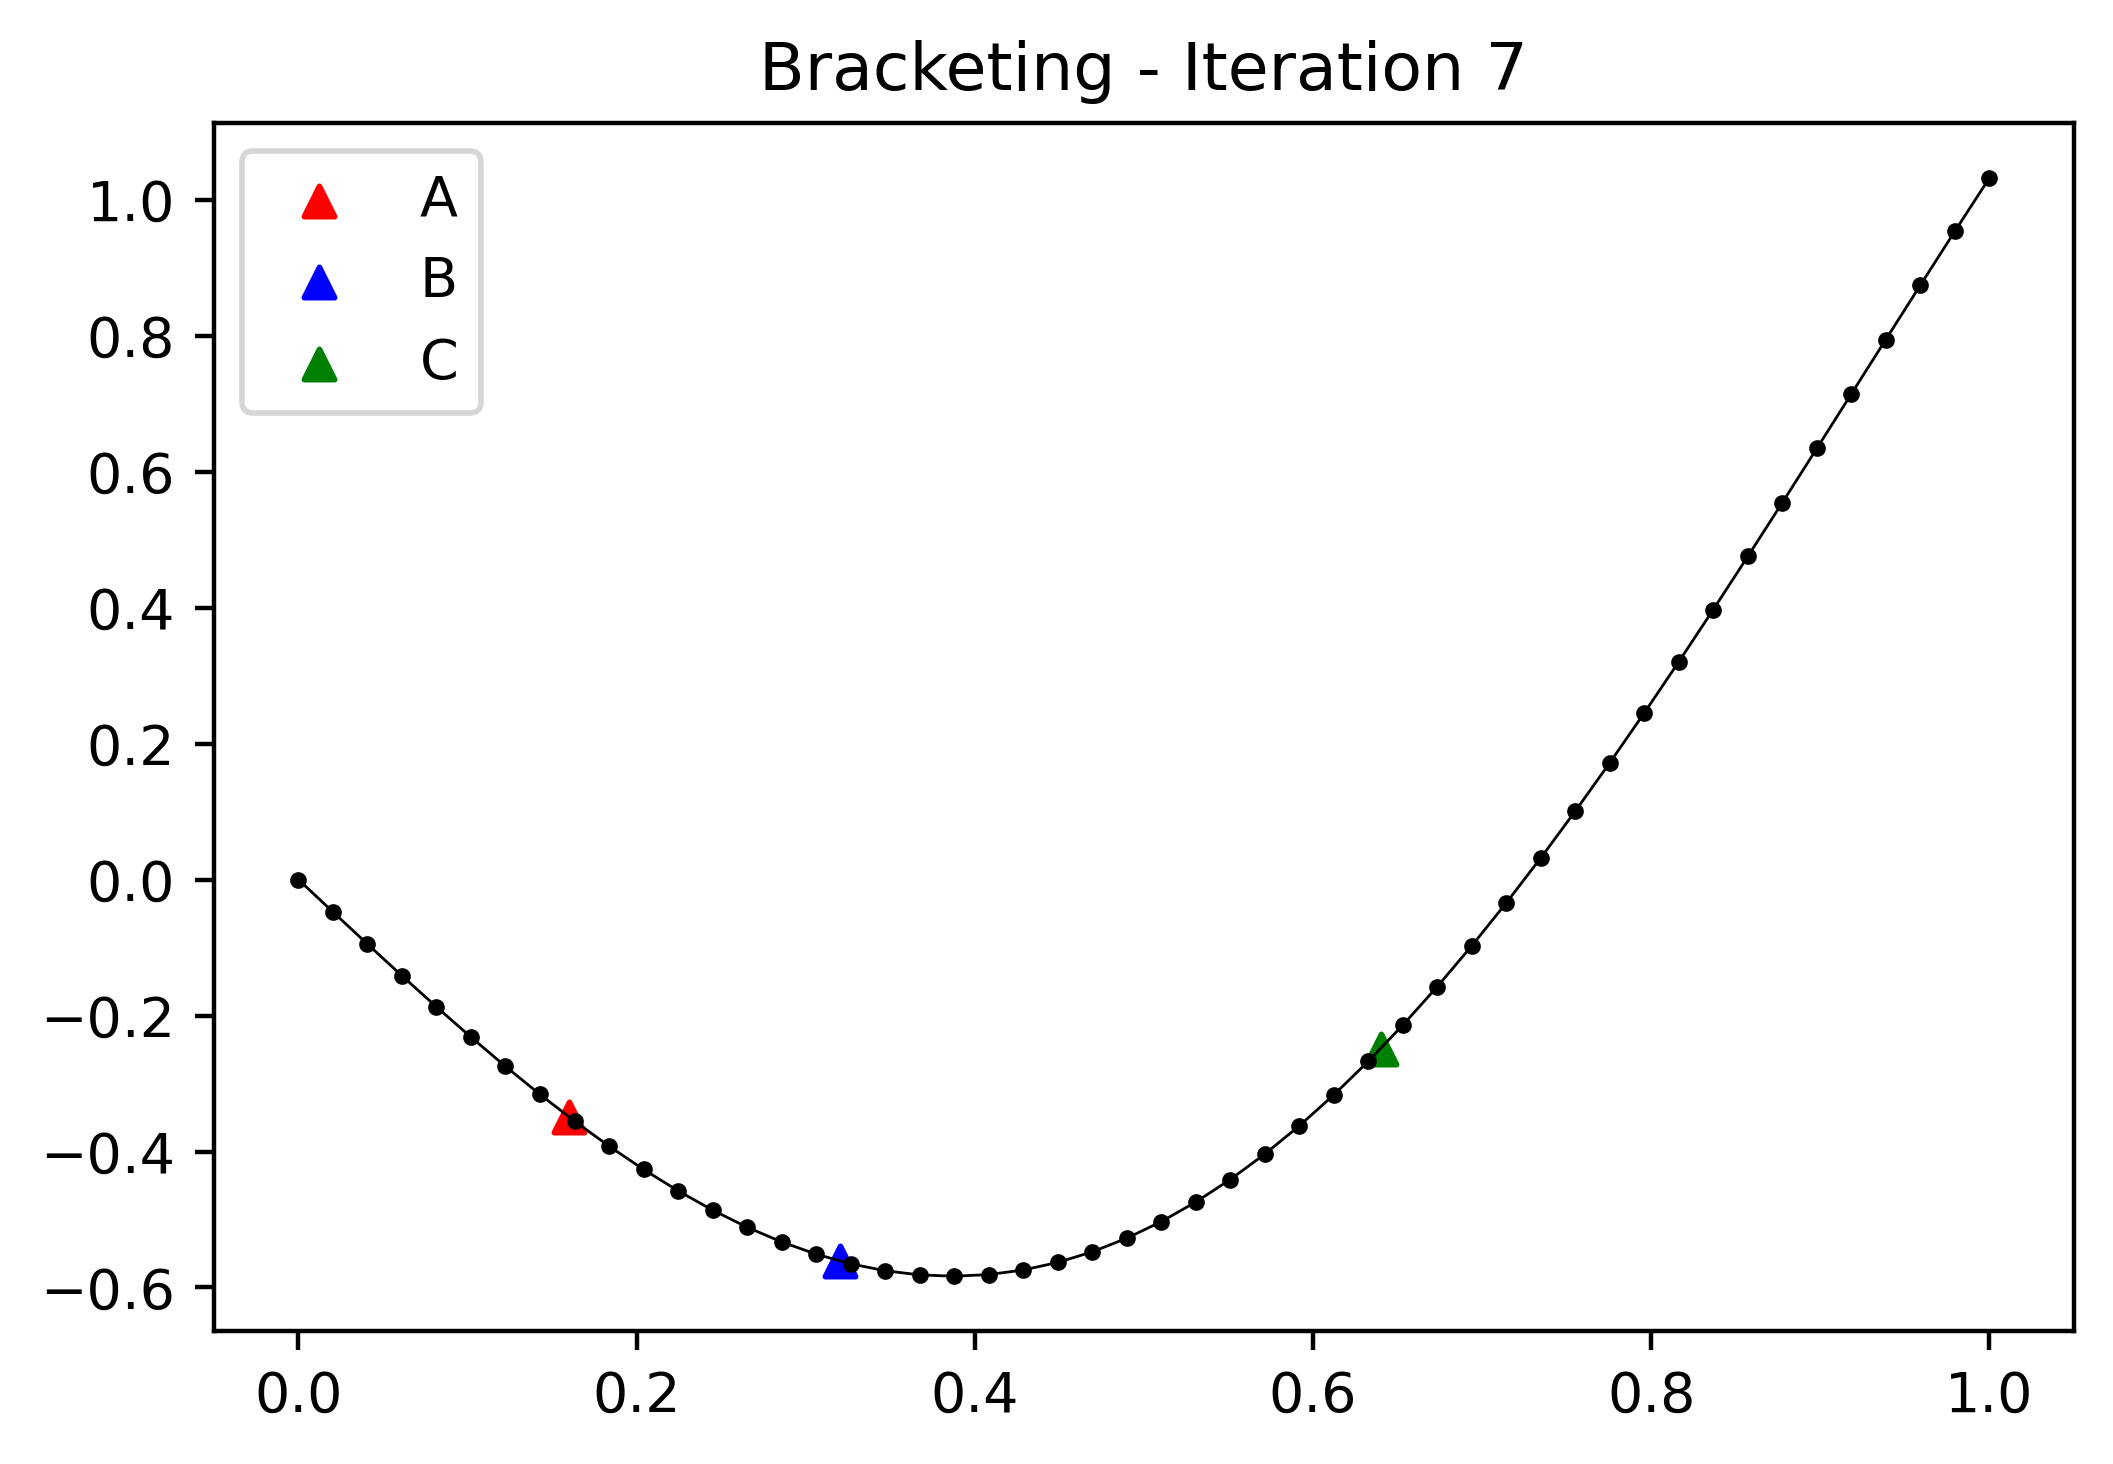

In [140]:
test_fun = lambda x: np.sin(x) - np.sin(10/3*x)
interval = np.linspace(0,1)
a, b, c, i_run = bracketing(a=0,s=0.01,k=2,f=test_fun)
plt.figure(figsize = (6,4), dpi=400)
plt.plot(interval, test_fun(interval), 'ko-', linewidth=0.5, markersize = 2)
plt.scatter(a, test_fun(a), s=30, c='r', label='A', marker='^')  
plt.scatter(b, test_fun(b), s=30, c='b', label='B', marker='^')  
plt.scatter(c, test_fun(c), s=30, c='g', label='C', marker='^')  
plt.legend()
plt.title(f'Bracketing - Iteration {i_run}')
plt.show()

As the above figure shows, the bracketing algorithm found the portion of the (local) minimum which results in f(a) > f(b) < f(c).

In the sectioning phase, the interval $[a, c]$ found in the bracketing phase is progressively narrowed down. The key question is which rule should be employed for this narrowing process to efficiently and reliably find the solution. The golden section search leverages the golden ratio, a mathematical constant that frequently occurs in nature (e.g., in the spiral arrangements of leaves) and is also prominent in art and architecture. In mathematical terms, two quantities are in the golden ratio if the ratio of their sum to the larger quantity is equal to their original ratio:

$$\frac{l_1 + l_2}{l_1} = \frac{l_1}{l_2} = \phi$$

These relationships can be expressed as the quadratic equation $\phi^2 - \phi - 1 = 0$, where the positive solution represents the golden ratio $\phi$:

$$\phi = \frac{1 + \sqrt{5}}{2} \approx 1.618033$$

The factor $\rho = \phi - 1 \approx 0.61803$ defines the proportion of the longer distance and is utilized in the provided code for this exercise. Consequently, the new points between $a$ and $b$ are calculated as:

$$c = b - \rho(b - a) \quad \text{and} \quad d = a + \rho(b - a)$$

Similar to the bracketing phase, these three points need to be evaluated to determine the location of the optimum and which portion can be disregarded. This can be achieved by examining whether $f(c) < f(d)$.

In the depicted scenario, the points $a$, $c$, and $d$ suggest that the optimum lies within the interval $[a, d]$. In the subsequent iteration, three points and their corresponding function values can be recycled, requiring the calculation of only one new point:

1. $a_{\text{new}} = a$
2. $b_{\text{new}} = d$
3. $d_{\text{new}} = c$
4. $c_{\text{new}}$ to be computed


The minimum is determined when the distance between the brackets $a$ and $c$ is less than a predetermined threshold $\varepsilon$. After $n$ iterations or if the interval size becomes smaller than the value $\varepsilon$, the minimum is pinpointed within the final interval $[a, b]$.

In [141]:
def sectioning(
        a: float,
        b: float,
        c: float,
        f: Callable,
        tol: float = 10e-3,
        max_it: float = 10e3,
        ):

    c_range = c - rho*(c-a)
    a_range = a + rho*(c-a)

    counter = 1

    while state == True:
        if f(c_range) < f(a_range):
            c = a_range
            a_range = c_range
            c_range = c - rho*(c-a)
        elif counter > max_it:
            print("Max. iterations reached!")
            break    
        else:
            a = c_range
            c_range = a_range
            a_range = a + rho*(c-a)

        if abs(a-c) < tol:
            print("\nThreshold reached")
            break
        counter += 1
    return a,c,counter


Threshold reached


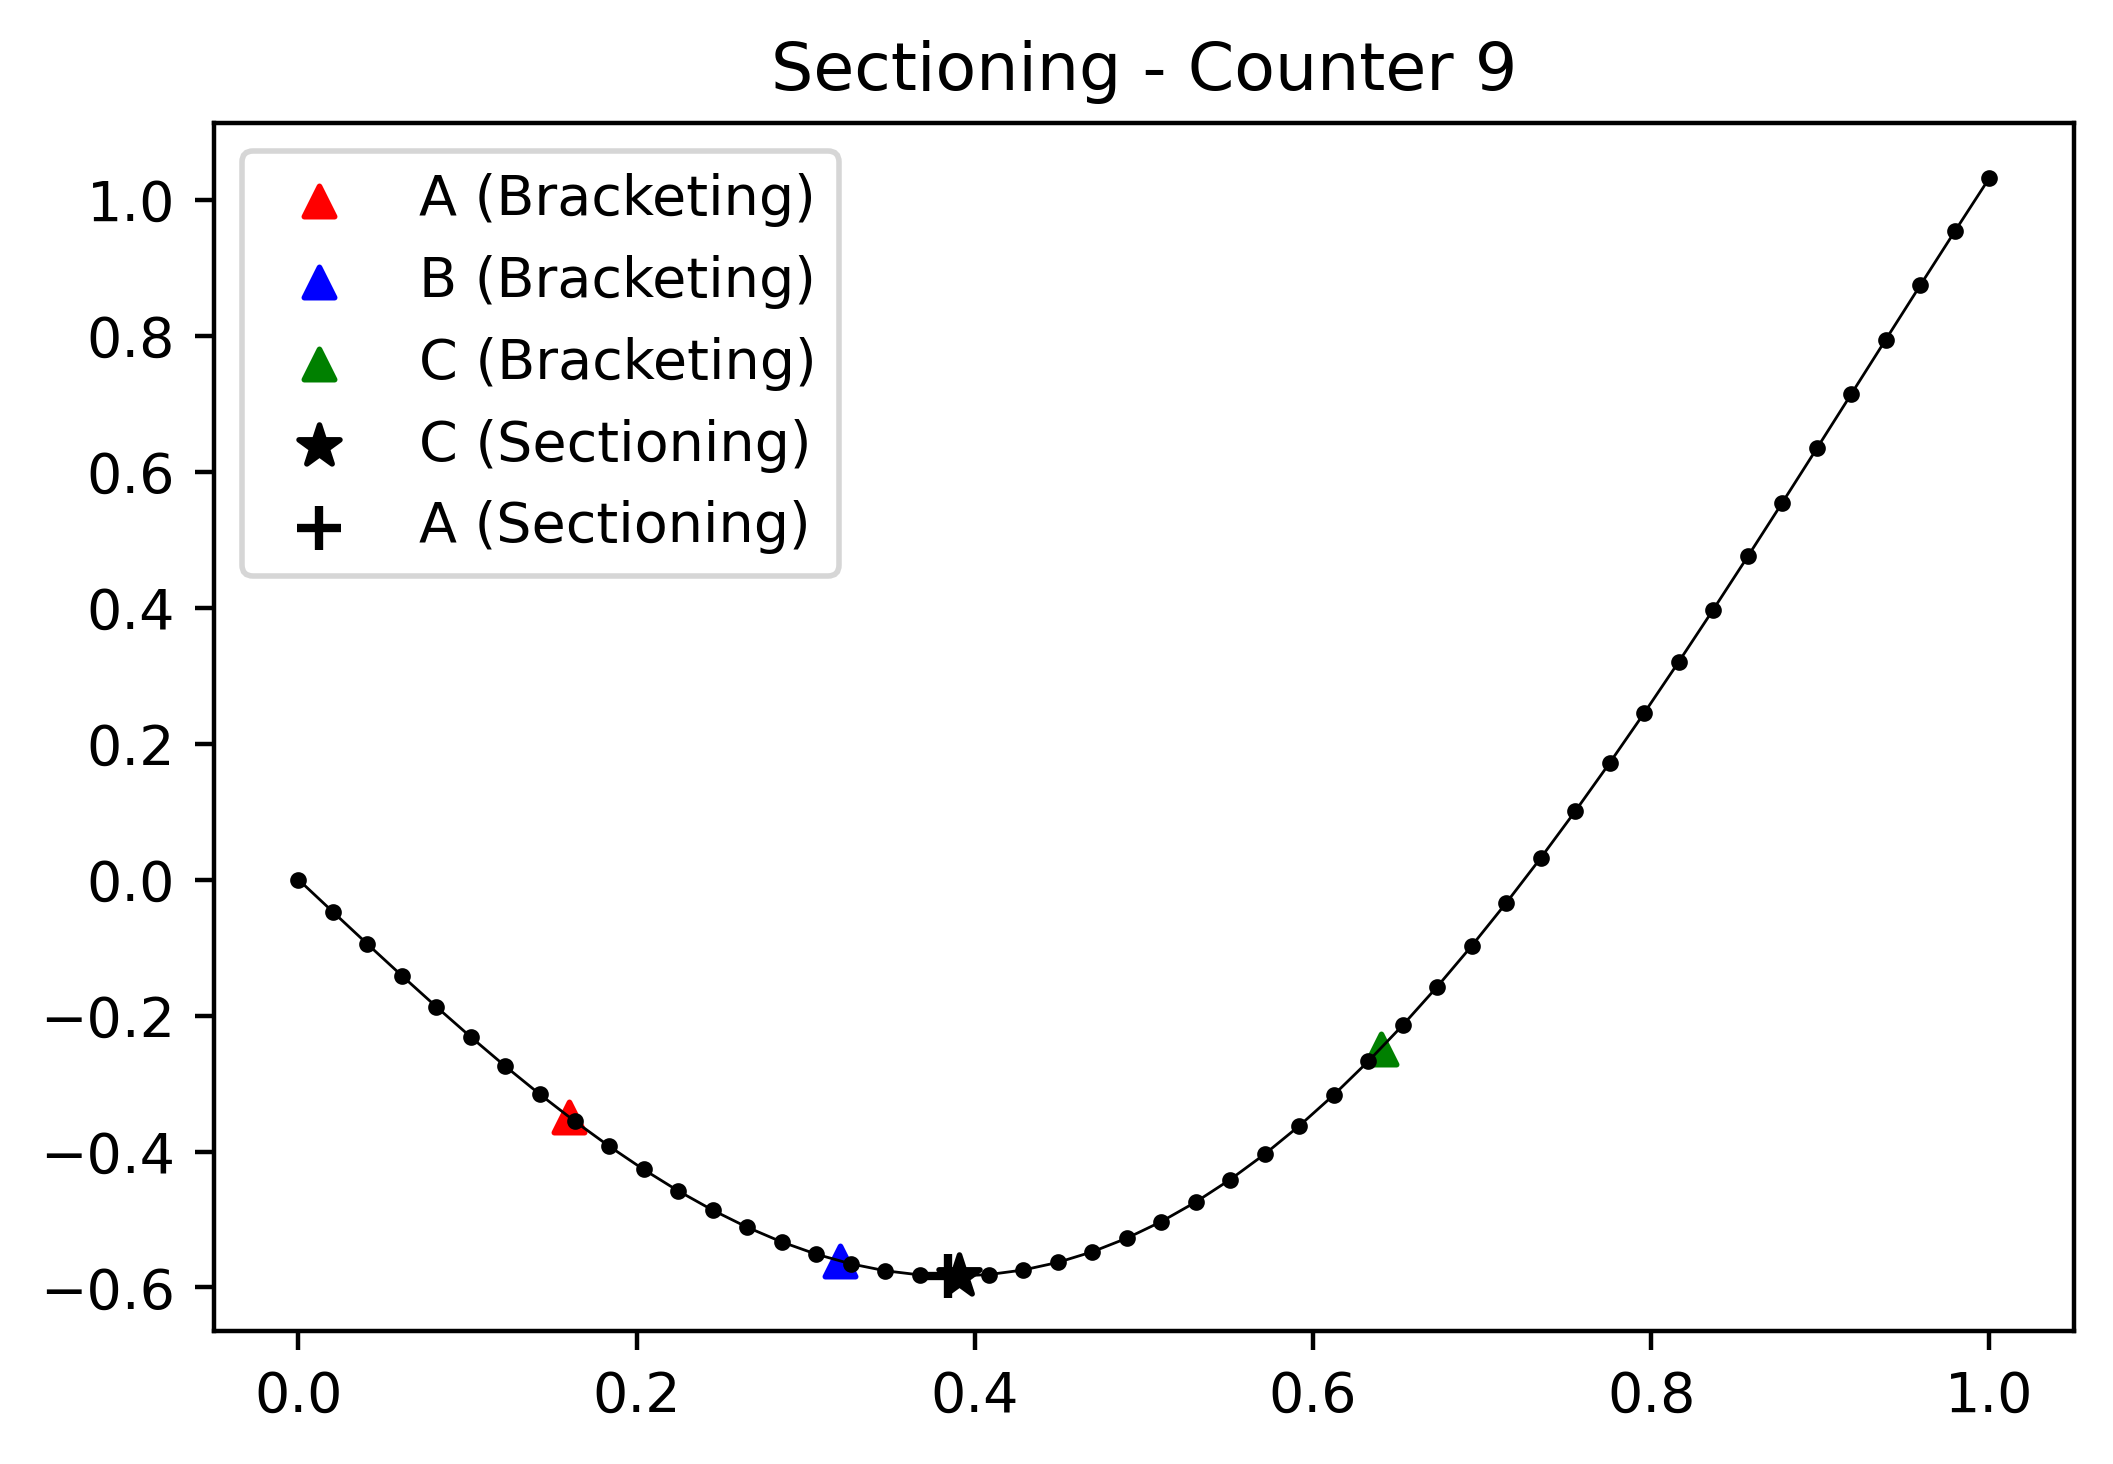

In [142]:
plt.figure(figsize = (6,4), dpi=400)
plt.scatter(a, test_fun(a), s=30, c='r', label='A (Bracketing)', marker='^')  
plt.scatter(b, test_fun(b), s=30, c='b', label='B (Bracketing)', marker='^')  
plt.scatter(c, test_fun(c), s=30, c='g', label='C (Bracketing)', marker='^')  
a,c, counter = sectioning(a, b, c,test_fun)
plt.plot(interval, test_fun(interval), 'ko-', linewidth=0.5, markersize = 2)
plt.scatter(c, test_fun(c), s=60, c='k', label='C (Sectioning)', marker='*')  
plt.scatter(a, test_fun(c), s=60, c='k', label='A (Sectioning)', marker='+')  
plt.legend()
plt.title(f'Sectioning - Counter {counter}')
plt.show()

As the figure shows, the sectioning algorithm found the (local) minimum based on the starting value, step size, and step expansion. 

Line search is a fundamental iterative optimization technique employed to locate a local minimum of a multivariate objective function $f(\mathbf{x})$. Before initiating the Line Search algorithm, it is imperative to determine the search direction. In one-dimensional (1D) problems, this is straightforward (if the function doesn't decrease in the positive direction, the search direction is negative). However, for higher-dimensional problems, finding the search direction is the first step, followed by the execution of the Line Search algorithm along this direction. Consequently, the n-dimensional (nD) problem is reduced to a 1D problem, and employing bracketing and sectioning methods, a local optimum can be identified for the proposed search direction.

There is no guarantee of finding the global optimum. The likelihood of discovering the global optimum can be enhanced by varying the starting point (initial optimization parameters) and adjusting the hyperparameters of the search algorithms.

In the line search, the nD optimization problem

$$\min_{\mathbf{x}} f(\mathbf{x})$$

transforms into the 1D optimization problem

$$
\min_{\alpha} f(\mathbf{x} + \alpha \mathbf{g})
$$

where $\mathbf{g}$ is the nD search direction, and $\alpha\$ is a scalar (1D) value.




In [143]:
###############################################
########### Main solution function : ##########
def line_search(
    f: Callable,
    alpha0: float,
    x0: np.ndarray,
    g: np.ndarray,
    s: float = 10e-2,
    k: float = 2.0,
    eps: float = 1e-2,
) -> Tuple[float, float, int]:
    """[summary]

    Args:
        f (Callable): Function to perform the line search on.
        alpha0 (float): Initial step parameter.
        x0 (np.ndarray): Starting position.
        g (np.ndarray): Search direction.
        s (float, optional): Line search step scalar. Defaults to 10e-2.
        k (float, optional): Line search step expansion. Defaults to 2.0.
        eps (float, optional): Termination condition eps. Defaults to 1e-2.

    Returns:
        Tuple[float, float, int]: bracket left, bracket right, number of function calls
    """

    line_fun = lambda alpha: f(x0 + alpha*g)

    a, b, c, i_run = bracketing(alpha0,s,k,line_fun)
    a,c, counter = sectioning(a, b, c,line_fun)
    f_calls = i_run + counter
    
    return a,c, f_calls

In [144]:
a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.01, k = 2, f = test_fun)
print(f"s = 0.01, k = 2, f(a) = {test_fun(a)}, f(b) = {test_fun(b)}, a = {a}, b = {b}, b-a = {b-a}, function calls = {f_calls} ")
a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.1, k = 2, f = test_fun)
print(f"s = 0.1, k = 2, f(a) = {test_fun(a)}, f(b) = {test_fun(b)}, a = {a}, b = {b}, b-a = {b-a}, function calls = {f_calls} ")
a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 1, k = 2, f = test_fun)
print(f"s = 1, k = 2, f(a) = {test_fun(a)}, f(b) = {test_fun(b)}, a = {a}, b = {b}, b-a = {b-a}, function calls = {f_calls} ")
a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.01, k = 4, f = test_fun)
print(f"s = 0.01, k = 4, f(a) = {test_fun(a)}, f(b) = {test_fun(b)}, a = {a}, b = {b}, b-a = {b-a}, function calls = {f_calls} ")
a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.1, k = 4, f = test_fun)
print(f"s = 0.1, k = 4, f(a) = {test_fun(a)}, f(b) = {test_fun(b)}, a = {a}, b = {b}, b-a = {b-a}, function calls = {f_calls} ")
a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 1, k = 4, f = test_fun)
print(f"s = 1, k = 4, f(a) = {test_fun(a)}, f(b) = {test_fun(b)}, a = {a}, b = {b}, b-a = {b-a}, function calls = {f_calls} ")


Threshold reached
s = 0.01, k = 2, f(a) = -0.5833895632776303, f(b) = -0.5833507783910257, a = 0.38421325900427794, b = 0.3905279554025739, b-a = 0.00631469639829596, function calls = 16 

Threshold reached
s = 0.1, k = 2, f(a) = -0.5833489030442318, f(b) = -0.5833371742770508, a = 0.3829710109982042, b = 0.3908643814960772, b-a = 0.007893370497873031, function calls = 13 

Threshold reached
s = 1, k = 2, f(a) = -1.9885782427002912, f(b) = -1.9885585392336536, a = -1.4221660011754556, b = -1.4314828612207744, b-a = -0.009316860045318842, function calls = 15 

Threshold reached
s = 0.01, k = 4, f(a) = -0.583333765229864, f(b) = -0.5833953600581601, a = 0.38260179800180266, b = 0.3891062930064963, b-a = 0.006504495004693633, function calls = 15 

Threshold reached
s = 0.1, k = 4, f(a) = -0.583410859344778, f(b) = -0.583293393947394, a = 0.3852182587523946, b = 0.39179606750059437, b-a = 0.006577808748199743, function calls = 12 

Threshold reached
s = 1, k = 4, f(a) = -1.988665206605290

The table below shows the results of the line search algorithm for the 1D function with differnt step sizes s and step expansion factors k. The results clearly indicate the high dependendcy of the step size and expansion size. For instance with a k = 2 and  s < 1.0, the same local minimum is found, whereas with an s = 1 a different solution is found. A similar behaviour is found with k = 4. 

| s | k | $f(a)$ | $f(b)$ | $f(b)-f(a)$ | $a$ | $b$ | $b-a$ | $\# function\;calls$ |
| :-: | :-: | :-: | :-: |:-: |:-: |:-: |:-: |:-: |
| 0.01 | 2 | -0.5834| -0.5834 | <img width=100/> 0.0 | 0.3842 | 0.3905 | 0.0063 | <img width=100/> 16
| 0.1 | 2 | -0.5833| -0.5833 | <img width=100/> 0.0 | 0.3829| 0.3909 | 0.0079 | <img width=100/> 13
| 1 | 2 | -1.9885 | -1.9886 | <img width=100/> 0.0 | -1.4221 | -1.4314 | -0.0093 | <img width=100/> 15
| 0.01 | 4 | -0.5833| -0.5834 | <img width=100/> -0.0001 | 0.3826| 0.3891 | 0.0066 | <img width=100/> 15
| 0.1 | 4 | -0.5834| -0.5833 | <img width=100/> 0.0001| 0.3862| 0.3871 | 0.0066 | <img width=100/> 12
| 1 | 4 | -1.9887| -1.9883 | <img width=100/> -0.0004 | -1.4262| -1.4271 | 0.0096 | <img width=100/> 16

## Task 2 ( nD - problem ) :

In this task, the already created code should be applied to the line search subproblem of the Rosenbrock function:

$$
f(\mathbf{x}) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2
$$

in the search direction \(\mathbf{g} = (-1, -2)^T\) starting at \(\mathbf{x}_0 = (3, -2)^T\).

The aim of this task is to:

$$
\min_{\alpha} f(\mathbf{x} + \alpha \mathbf{g})
$$

and evaluate $\alpha$, $f(\alpha)$, the optimal solution $\mathbf{x}^*$ for the subproblem, and the number of function calls. 


In [145]:
# Get the 2D test function : 
f = tf.test_function(1)[0]
# (1) ... Rosenbrock function, (2) ... Himmelblau function, (3) ... Rastrigin function

# Define the starting point, search direction, and call line_search
x0 = np.array([[3, -2]])
g = np.array([[-1, 1]])

alpha0 = 0
a,b, f_calls = line_search(alpha0=alpha0, x0=x0, g=g, s=1, k=2, f = f)


# Take the mean value of the bounds as the optimal distance
alpha = 0.5*(a + b)


# Now I know the distance, but not the solution in the 2D parameter space! -->
# Starting point of the line search (if α0 is not 0)
X0 = x0 + alpha0*g

# Minimizer x*
Xs = x0 + alpha*g 
print('minimum found at α =', alpha, 'thus at point x* = ', Xs, "with the corresponding function values f(α) = ", f(Xs))


Threshold reached
minimum found at α = 2.3815994425321545 thus at point x* =  [[0.61840056 0.38159944]] with the corresponding function values f(α) =  [0.14568534]


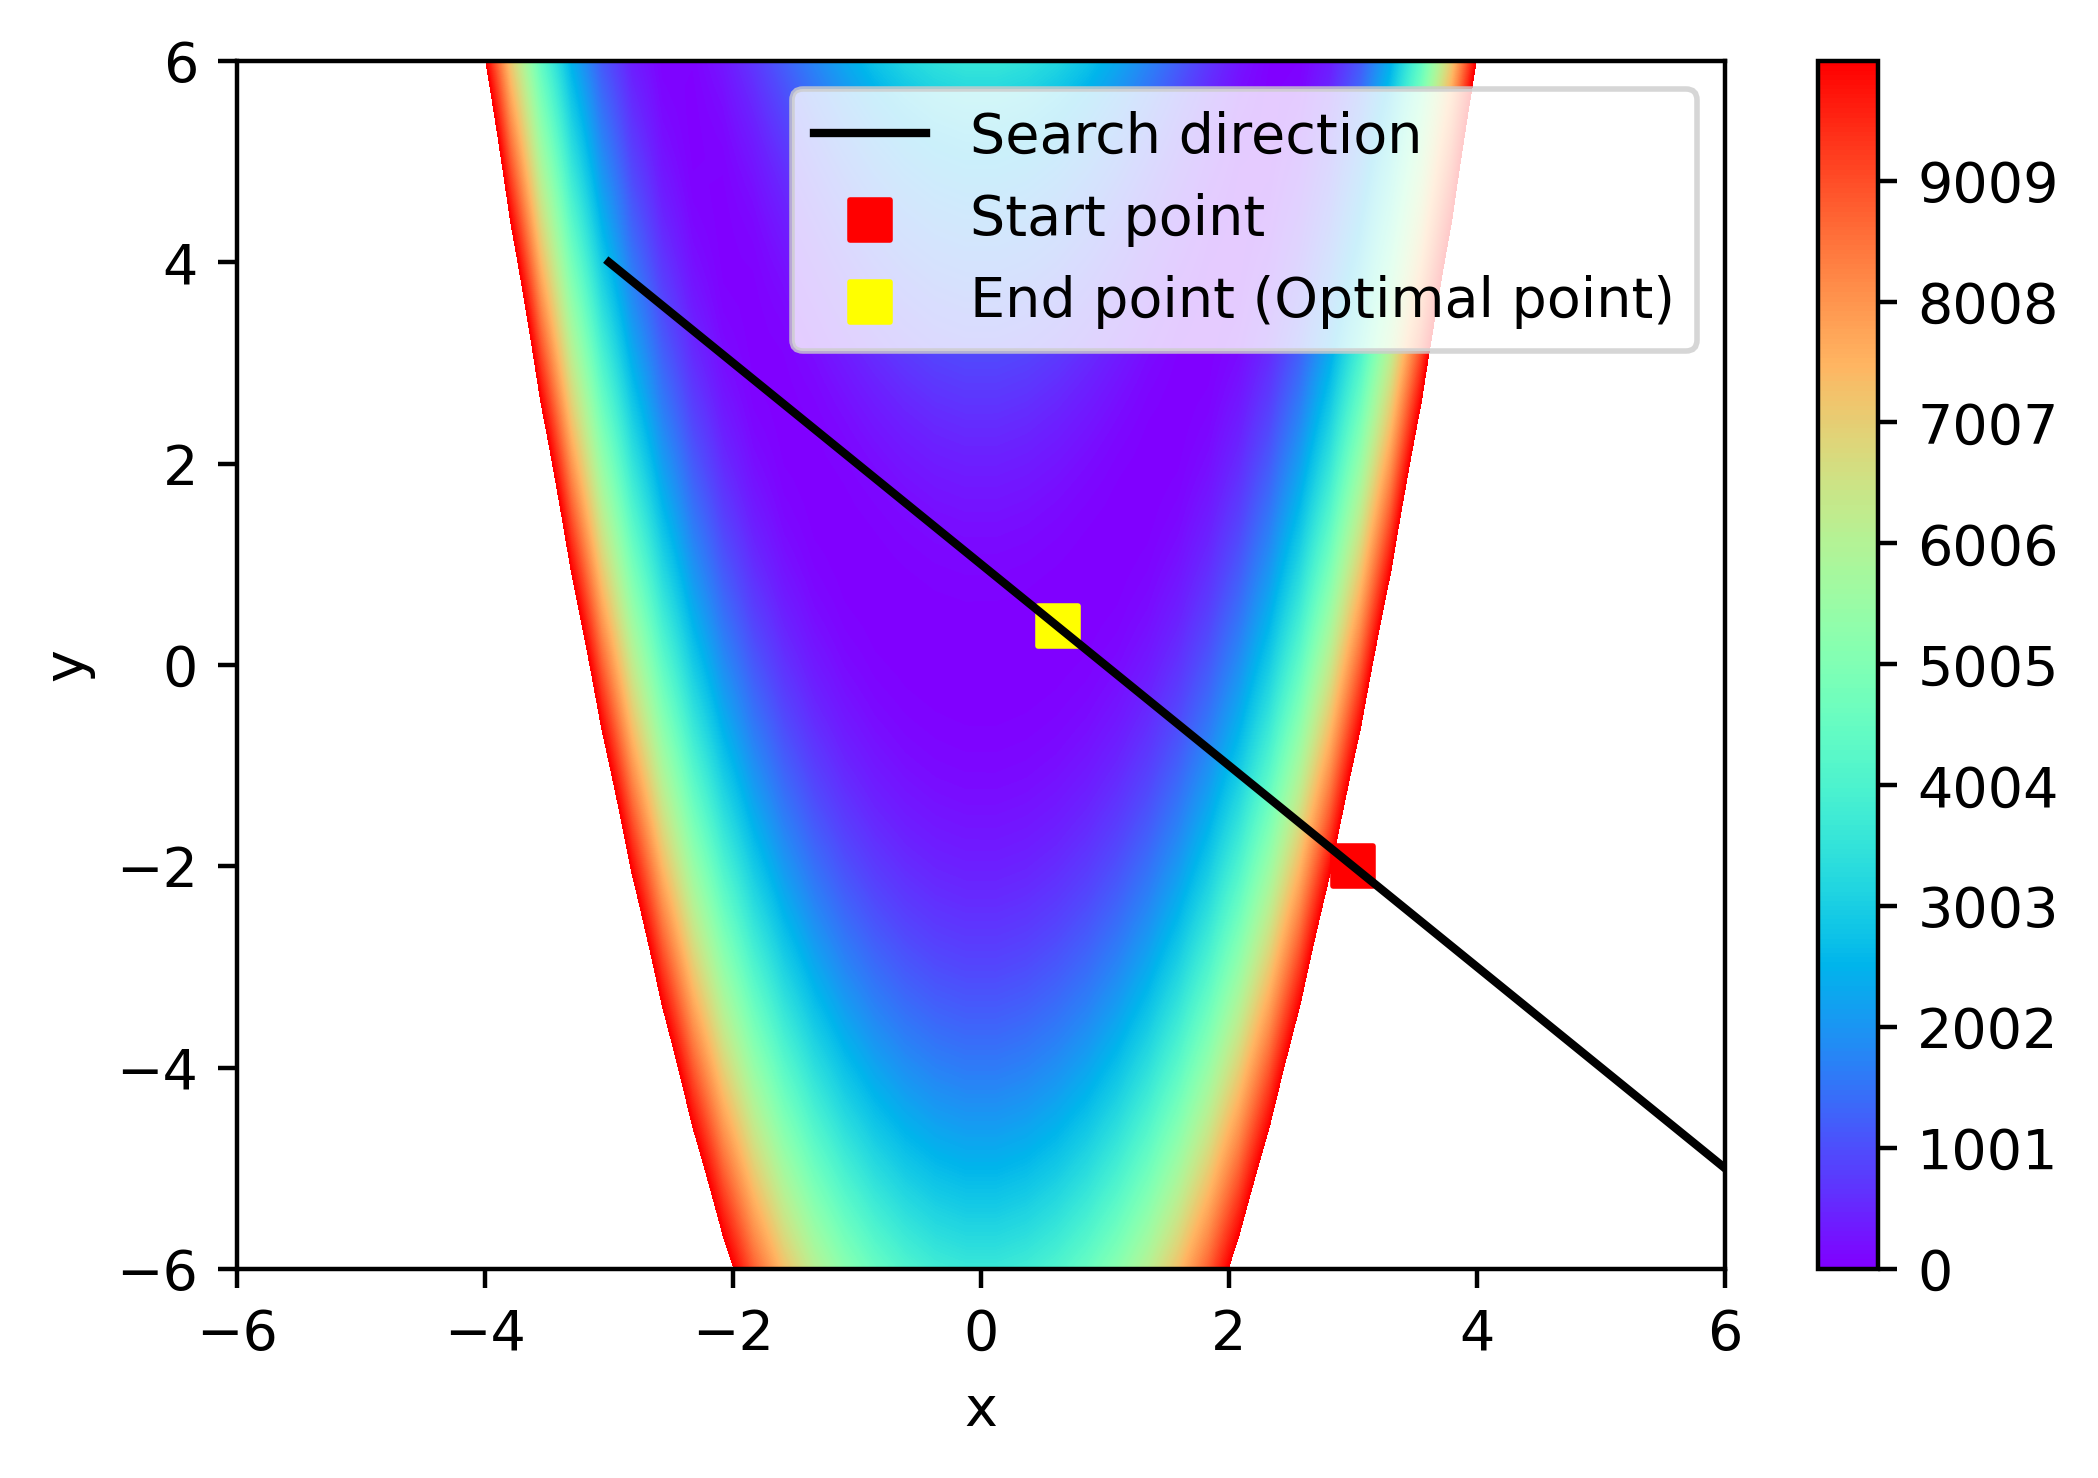

In [146]:
fig, ax = plt.subplots(figsize=(6,4), dpi=400)
x = np.linspace(-6,6,50)
xx, yy = np.meshgrid(x,x)
zz = f(np.column_stack((xx.flatten(), yy.flatten())))
cf = ax.contourf(xx, yy, zz.reshape(xx.shape), levels=np.linspace(0, 10000, 1000), cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(cf)

α_v = np.linspace(-3,6,50)
X = α_v[:,None]*g + x0
ax.plot(X[:,0],X[:,1],'black',label="Search direction")

ax.scatter(x0[0,0], x0[0,1],marker="s",label="Start point",s=50,color='red')
ax.scatter(Xs[0,0], Xs[0,1],marker="s",label="End point (Optimal point)",s=50,color='yellow')
ax.legend()

plt.show()

The figure above shows the plotted Rosenbrock function with its evaluated values. In addition, the solution of the line search algorithm is shown, in particular the search direction (in black), the starting point (in red), and the end point (as optimal point in yellow).

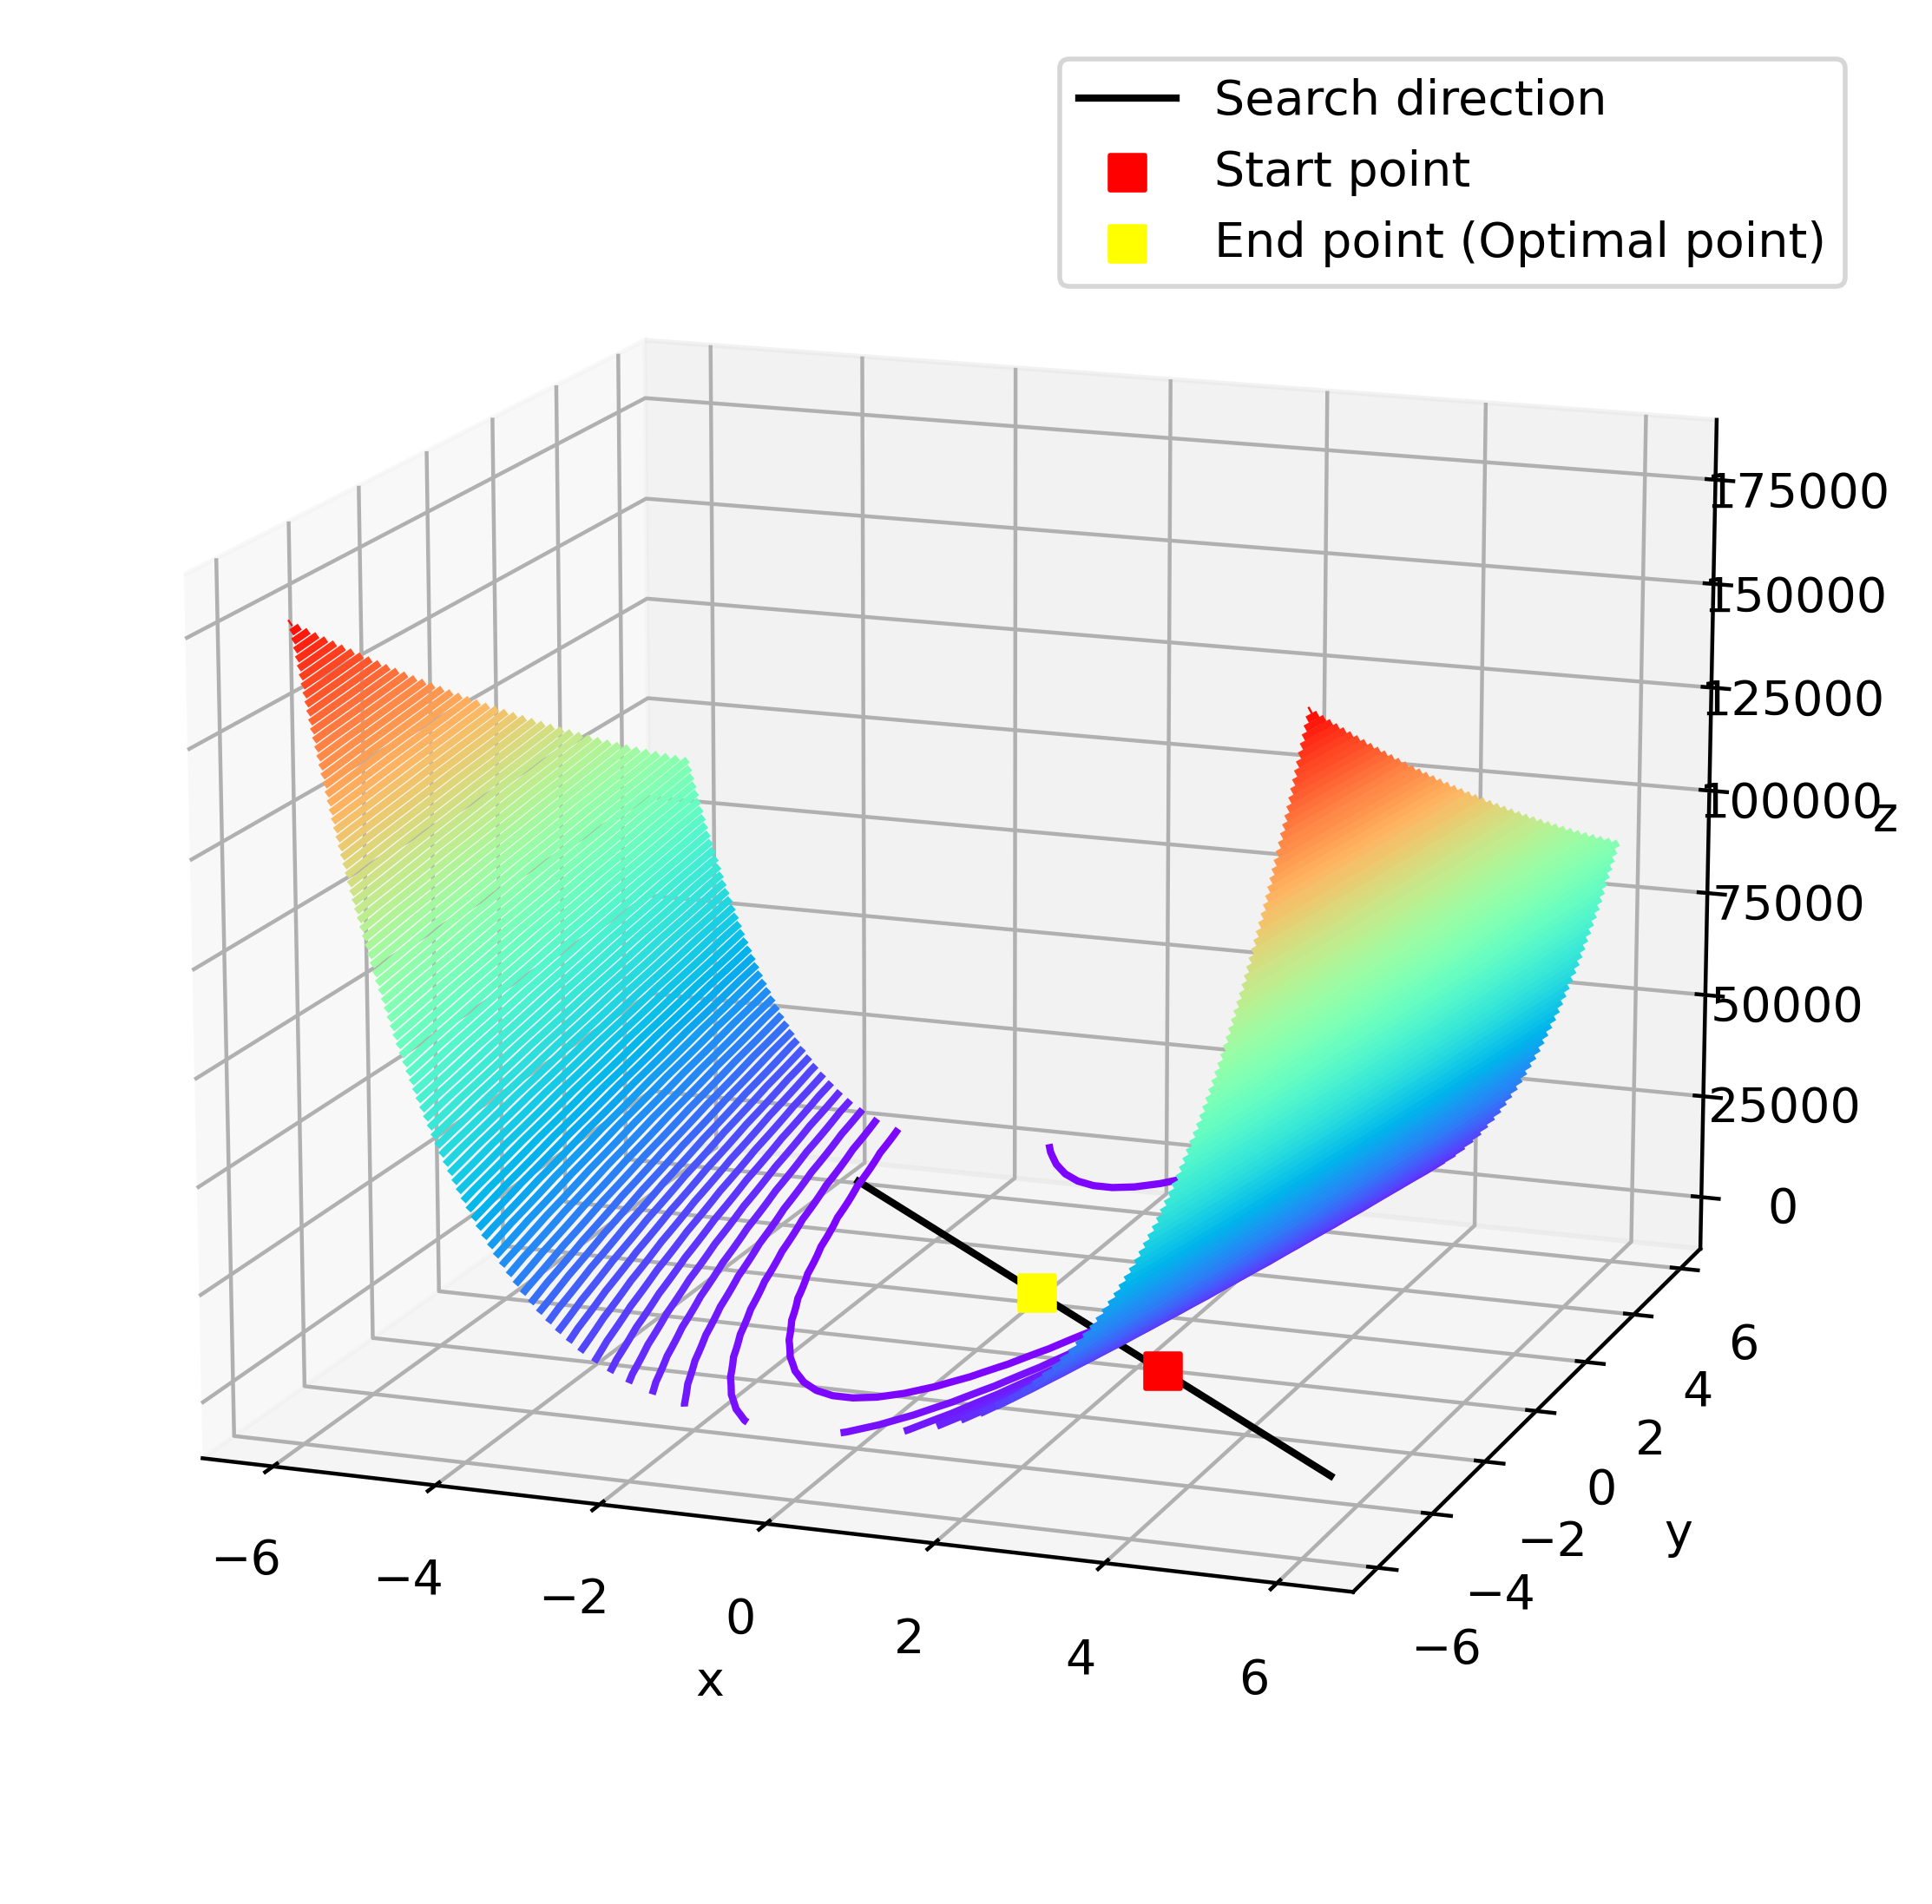

In [147]:
fig = plt.figure(figsize=((9,7)), dpi = 400)
ax = plt.axes(projection='3d')
ax.contour3D(xx,yy,zz.reshape(xx.shape),100,cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

ax.plot(X[:,0],X[:,1],0,'black',label="Search direction")
ax.scatter(x0[0,0], x0[0,1], 0,marker="s",label="Start point",s=50,color='red')
ax.scatter(Xs[0,0], Xs[0,1], 0, marker="s",label="End point (Optimal point)",s=50,color='yellow')
ax.legend()

ax.view_init(15, 290)

The 3D figure above shows the same results as in the contour plot.

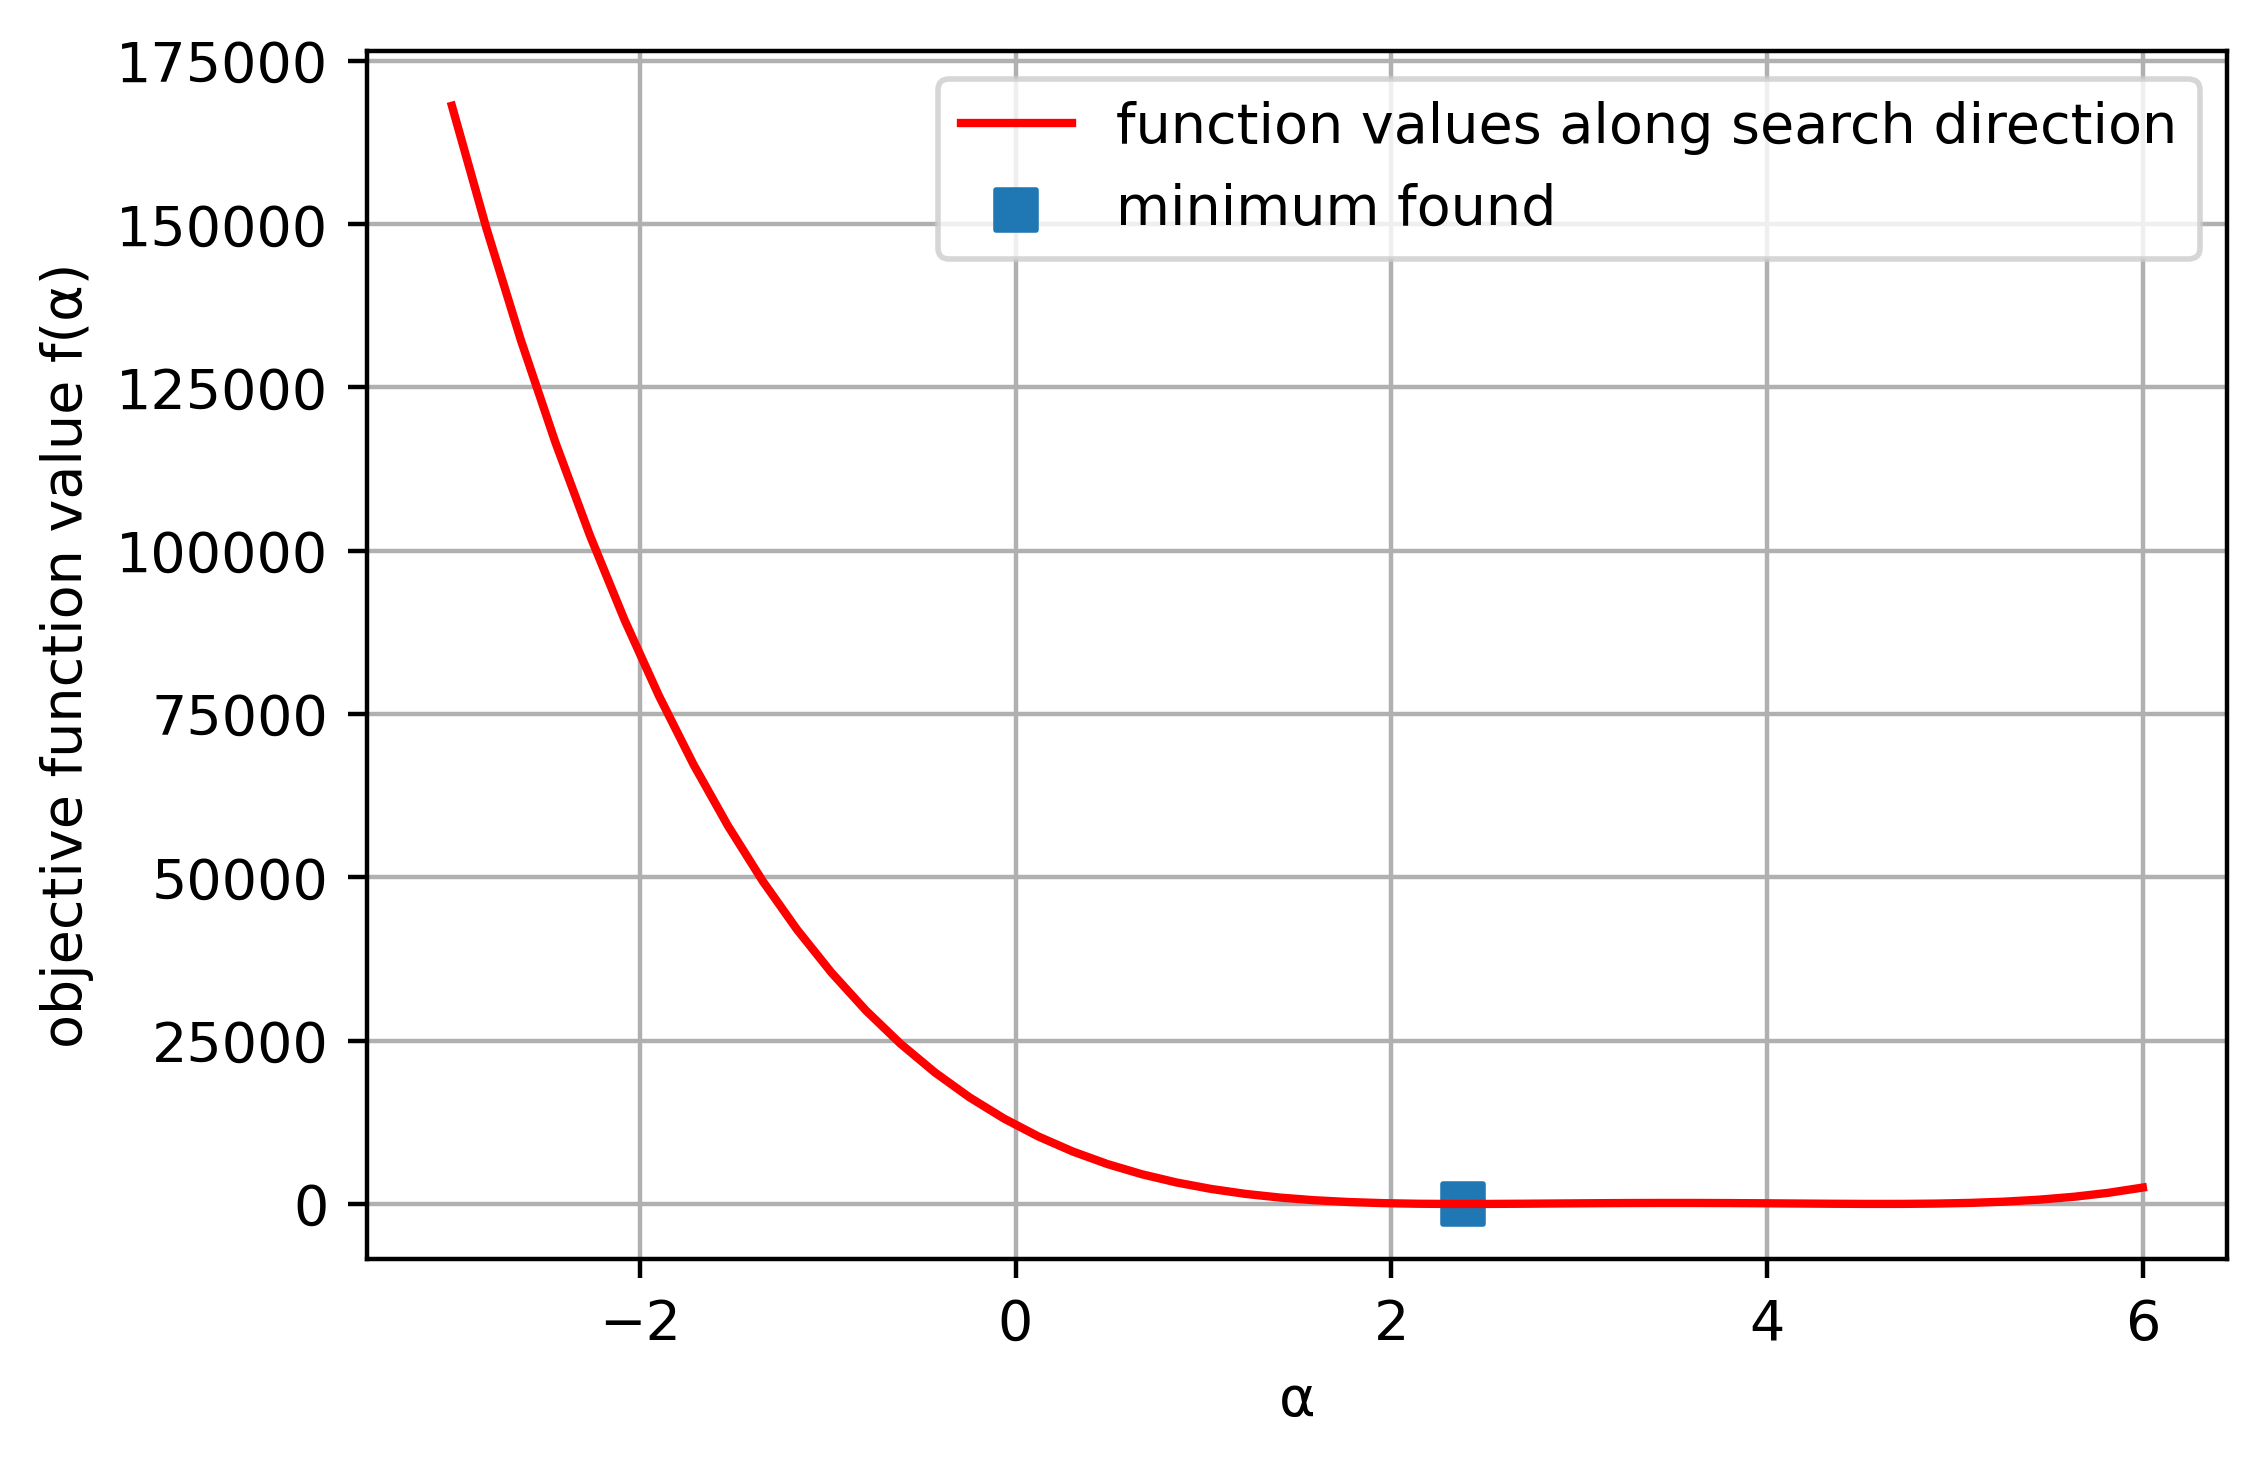

In [148]:
yav = f(X)
fig = plt.figure(figsize = (6,4), dpi = 400)
pyplot.plot(α_v,yav,'r',label="function values along search direction")
pyplot.scatter(alpha,f(x0+alpha*g),marker="s",label="minimum found",s=50)
pyplot.xlabel('α') 
pyplot.ylabel('objective function value f(α)')
pyplot.legend(); pyplot.grid()
plt.show()

The above figure shows the evalued objective function along the search direction $\alpha$. Herein, the (local) minimum of the seach direction is found at $\alpha = $ 2.3816. 